In [6]:
import os
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from cifar10_data import CIFAR10RandomLabels
from torch.autograd import Variable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
class MyAlexNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(MyAlexNetFeatureExtractor, self).__init__()
        self.Conv2d_0 = model.features[0]
        self.ReLU_1 = model.features[1]
        self.MaxPool2d_2 = model.features[2]
        self.Conv2d_3 = model.features[3]
        self.ReLU_4 = model.features[4]
        self.MaxPool2d_5 = model.features[5]
        self.Conv2d_6 = model.features[6]
        self.ReLU_7 = model.features[7]
        self.Conv2d_8 = model.features[8]
        self.ReLU_9 = model.features[9]
        self.Conv2d_10 = model.features[10]
        self.ReLU_11 = model.features[11]
        self.MaxPool2d_12 = model.features[12]
        self.linear = model.classifier
    def forward(self, x):
        out0 = self.Conv2d_0(x)
        out1 = self.ReLU_1(out0)
        out2 = self.MaxPool2d_2(out1)
        out3 = self.Conv2d_3(out2)
        out4 = self.ReLU_4(out3)
        out5 = self.MaxPool2d_5(out4)
        out6 = self.Conv2d_6(out5)
        out7 = self.ReLU_7(out6)
        out8 = self.Conv2d_8(out7)
        out9 = self.ReLU_9(out8)
        out10 = self.Conv2d_10(out9)
        out11 = self.ReLU_11(out10)
        out12 = self.MaxPool2d_12(out11)
        out12 = out12.view(out12.size(0), -1)
        out13 = self.linear(out12)
        # return reshaped tensor to calculate the spectral norm
        f0 = out0.view(out0.size(0),-1).data
        f2 = out2.view(out2.size(0),-1).data
        f3 = out3.view(out3.size(0),-1).data
        f5 = out5.view(out5.size(0),-1).data
        f6 = out6.view(out6.size(0),-1).data
        f7 = out7.view(out7.size(0),-1).data
        f8 = out8.view(out8.size(0),-1).data
        f9 = out9.view(out9.size(0),-1).data
        f10 = out10.view(out10.size(0),-1).data
        return f0,f2,f3,f5,f6,f7,f8,f9,f10

In [9]:
def cal_margin(trainloader, model):
#     model = AlexNet(num_classes)
#     model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
#     model.load_state_dict(model_state)
    margin = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        c = b.topk(2)[0][:,1].data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            margin.append(bnp[j,tar[j]]-c[j])
    margin = np.array(margin)
    return margin

In [10]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader_random = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=1.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [11]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=0.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [20]:
Lipschitz = np.zeros(6)
Lipschitz_random = np.zeros(6)
comp = np.zeros(6)
comp_random = np.zeros(6)
epoch = np.array([10,30,50,70,90,110])
for i in range(6):
    model = AlexNet(10)
    model_state = torch.load('model_'+str(epoch[i]), map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state)
    model.eval()
    A_spectral = cal_spectral(trainloader, model)
    Lipschitz[i] = cal_Lipschitz(A_spectral, model)
    comp[i] = cal_complexity(A_spectral, model)
    model_random = AlexNet(10)
    model_random_state = torch.load('model_'+str(epoch[i])+'_random', map_location=lambda storage, loc: storage)
    model_random.load_state_dict(model_random_state)
    model_random.eval()
    A_spectral_random = cal_spectral(trainloader_random, model_random)
    Lipschitz_random[i] = cal_Lipschitz(A_spectral_random, model_random)
    comp_random[i] = cal_complexity(A_spectral_random,model_random)

In [33]:
excess_risk = np.array([29.11,31.81,32.77,31.37,31.19,31.13])
excess_risk_random = np.array([1.06, 24.25, 80.27, 88.17, 88.81, 88.87])

In [26]:
epoch = np.array([20,40,60,80,100,120])

In [31]:
norm_Lipschitz_random = Lipschitz_random/0.1

array([ 0.10043429,  0.51704399,  3.43628067,  4.63329344,  4.79205982,
        4.87309979])

array([ 1.77605196,  2.94452619,  3.3939385 ,  3.59423747,  3.63733924,
        3.65380416])

In [34]:
norm_excess_risk = excess_risk/100.0
norm_excess_risk_random = excess_risk_random/100.0
norm_Lipschitz_random = Lipschitz_random/10.0
norm_Lipschitz = Lipschitz/10.0
norm_comp = comp/900000.0
norm_comp_random = comp_random/900000.0


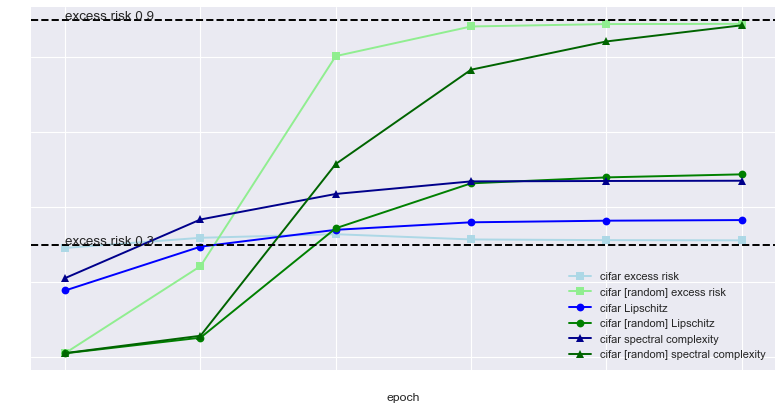

In [47]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(epoch,norm_excess_risk, label = 'cifar excess risk', marker = 's', color = 'lightblue')
plt.plot(epoch,norm_excess_risk_random, label = 'cifar [random] excess risk', marker = 's', color = 'lightgreen')
plt.plot(epoch,norm_Lipschitz, label = 'cifar Lipschitz', marker = 'o', color = 'blue')
plt.plot(epoch,norm_Lipschitz_random, label = 'cifar [random] Lipschitz', marker = 'o', color = 'green')
plt.plot(epoch,norm_comp, label = 'cifar spectral complexity', marker = '^', color = 'darkblue')
plt.plot(epoch,norm_comp_random, label = 'cifar [random] spectral complexity', marker = '^', color = 'darkgreen')
plt.axhline(y=.3, color = 'black', ls = 'dashed')
plt.axhline(y=.9, color = 'black', ls = 'dashed')
plt.text(20, .3, r'excess risk 0.3')
plt.text(20, .9, r'excess risk 0.9')
plt.legend()
plt.xlabel('epoch')
plt.savefig('analysis')
plt.show()

In [25]:
comp_random

array([   9489.1908212 ,   51156.93973086,  463467.7691459 ,
        689761.8366527 ,  757568.04682718,  796301.46898036])

In [22]:
model = AlexNet(10)
model_state = torch.load('model_300_cifar', map_location=lambda storage, loc: storage)
model.load_state_dict(model_state)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=10)
)

In [9]:
model_random = AlexNet(10)
model_random_state = torch.load('model_300_random', map_location=lambda storage, loc: storage)
model_random.load_state_dict(model_random_state)
model_random.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=10)
)

In [23]:
margin = cal_margin(trainloader, model)
margin_random = cal_margin(trainloader_random, model_random)

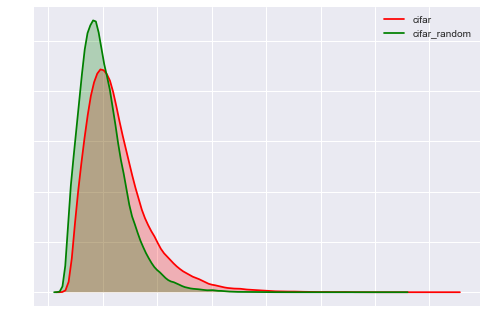

In [113]:
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('margin.pdf', bbox_inches='tight')
plt.show()

In [13]:
def cal_spectral(trainloader, model):
    FeatureExtractor = MyAlexNetFeatureExtractor(model)
    average = np.zeros(5)
    count = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        count += inputs.shape[0]
        inp = inputs
        inp_flat = inp.view(inp.size(0),-1)
        f0,f2,f3,f5,f6,f7,f8,f9, f10 = FeatureExtractor(Variable(inp))
        average[0]+= sum(torch.norm(f0,2,dim = 1)/torch.norm(inp_flat,2,dim = 1))
        average[1]+= sum(torch.norm(f3,2,dim = 1)/torch.norm(f2,2,dim = 1))
        average[2]+= sum(torch.norm(f6,2,dim = 1)/torch.norm(f5,2,dim = 1))
        average[3]+= sum(torch.norm(f7,2,dim = 1)/torch.norm(f8,2,dim = 1))
        average[4]+= sum(torch.norm(f10,2,dim = 1)/torch.norm(f9,2,dim = 1))
    average = average/float(count)  
    return average

In [14]:
def cal_Lipschitz(A, model):
    ### Input the spectral norms A calculated by cal_spectral
    Lip = 1
    for i in range(A.shape[0]):
        Lip *= A[i]
    Lip *= np.linalg.norm(model.classifier.weight.data.numpy(), ord = 2)
    return Lip

In [15]:
def cal_complexity(A, model):
    ### Input the spectral norms A calculated by cal_spectral
    complexity = cal_Lipschitz(A, model)
    plu = 0
    # 1-norm
    indices = [0,3,6,8,10]
    for i in range(A.shape[0]):
        A1 = torch.norm(model.features[indices[i]].weight.view(-1).data, p = 1)
        plu += (A1/A[i])**(2.0/3)
    lin_spec = np.linalg.norm(model.classifier.weight.data.numpy(), ord = 2)
    lin_1 = torch.norm(model.classifier.weight.view(-1).data, p = 1)
    plu += (lin_1/lin_spec)**(2.0/3)
    plu = plu**(3.0/2)
    complexity = complexity * plu
    return complexity

In [115]:
A_spectral = cal_spectral(trainloader, model)
A_spectral_random = cal_spectral(trainloader_random, model_random)

In [118]:
comp = cal_complexity(A_spectral, model)
comp_random = cal_complexity(A_spectral_random, model_random)

In [119]:
### Normalize
comp = comp/10000.0
comp_random = comp_random/10000.0

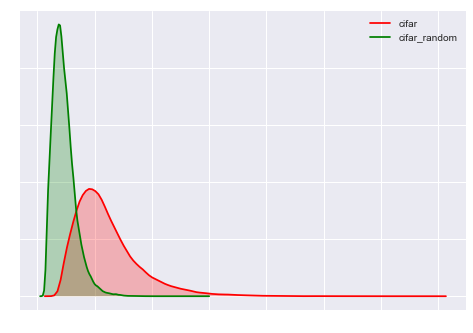

In [120]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin/comp, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random/comp_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('margin_normalized.pdf', bbox_inches='tight')
plt.show()

## calculate margin distribution

In [39]:
margins = []
for i in range(6):
    model = AlexNet(10)
    model_state = torch.load('model_'+str(epoch[i]), map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state)
    model.eval()
    margins.append(cal_margin(trainloader, model))

In [40]:
norm_margins = []
for i in range(6):
    norm_margins.append(margins[i]/comp[i])

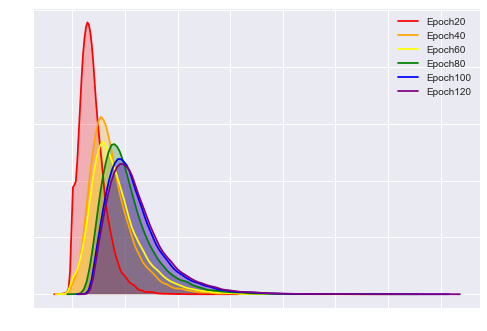

In [48]:
colors = ['red','orange', 'yellow', 'green','blue','purple' ]
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
for i in range(6):
    sns.distplot(margins[i], hist=False, color=colors[i], kde_kws={"shade": True}, label = 'Epoch'+str(epoch[i]))
plt.savefig('margin_epoch')
plt.show()

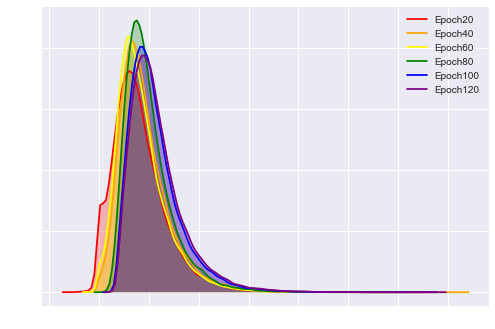

In [46]:
colors = ['red','orange', 'yellow', 'green','blue','purple' ]
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
for i in range(6):
    sns.distplot(norm_margins[i], hist=False, color=colors[i], kde_kws={"shade": True}, label = 'Epoch'+str(epoch[i]))
plt.savefig('norm_margin_epoch')
plt.show()